In [1]:
from rdkit import Chem
import numpy as np
import pandas as pd
from IPython.display import display
import tqdm

# Load simulator data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/action_dataset.csv", index_col=0)

In [3]:
dataset

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
0,CON(C)C(=O)c1ccc(O)nc1,CC(C)CC(=O)c1ccc(O)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH:1]([CH3:2])[CH2:3][C:4](=[O:5])[c:6...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH:1]([CH3:2])[CH3:3],2,3,[[1.0]],[[1.0]],0
25624,CON(C)C(=O)c1ccc(Cl)nc1N,COc1cc(C)c(F)cc1C(=O)c1ccc(Cl)nc1N,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,2,9,[[1.0]],[[1.0]],0
26279,CON(C)C(=O)c1ccc(Cl)nc1,O=Cc1ccc(Cl)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[],0
195170,CON(C)C(=O)c1cncc(C#Cc2ccccc2)c1,O=Cc1cncc(C#Cc2ccccc2)c1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[[1.0]],0
27114,CON(C)C(=O)c1cccnc1Cl,CC(=O)c1cccnc1Cl,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][n...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],0
...,...,...,...,...,...,...,...,...,...,...,...
448339,OCCC(F)(F)C(F)(F)C(F)(F)F,O=P([O-])(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F,[OH:0][CH2:1][CH2:2][C:3]([F:4])([F:5])[C:6]([...,[O:0]=[P:1]([O-:2])([C:3]([F:4])([F:5])[CH3:6]...,[OH:0][CH2:1][CH2:2][CH:3]([F:4])[F:5],[O:0]=[PH:1]([O-:2])[C:7]([F:8])([F:9])[C:10](...,3,1,[[1.0]],[[1.0]],377459
448392,CCNC(=O)n1nc(N)c2cc(C(F)(F)F)ccc21,CCN=C=O,[CH3:0][NH:1][C:2](=[O:3])[n:4]1[n:5][c:6]([NH...,[CH3:0][N:1]=[C:2]=[O:3],[CH:2](=[O:3])[n:4]1[n:5][c:6]([NH2:7])[c:8]2[...,[CH2:2]=[O:3],2,2,[[1.0]],[[2.0]],377488
448417,O=P(C(F)(F)C(F)(F)F)(C(F)(F)C(F)(F)F)C(F)(F)C(...,O=P([O-])(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F,[O:0]=[P:1]([CH3:2])([CH3:3])[C:4]([F:5])([F:6...,[O:0]=[P:1]([O-:2])([CH3:3])[CH3:4],[CH:4]([F:5])([F:6])[C:7]([F:8])([F:9])[F:10],[O-:2],4,2,[[1.0]],[[1.0]],377507
448458,CCOc1ccc(C(C)(C)COCc2ccc(F)c(Oc3ccccc3)c2)cc1,CCOc1ccc(C(C)(C)CO)cc1,[CH3:0][O:1][CH2:2][c:3]1[cH:4][cH:5][c:6]([F:...,[H:0],[CH3:2][c:3]1[cH:4][cH:5][c:6]([F:7])[c:8]([O:...,[H:0],2,0,[[1.0]],[],377535


In [233]:
dataset["rbond"].value_counts()

[[1.0]]                   70326
[[1.0, 1.0]]              10240
[[2.0]]                    8198
[[3.0]]                     997
[[1.0, 1.0, 1.0]]           893
[[2.0, 1.0]]                275
[[1.0, 2.0]]                193
[[]]                        184
[[2.0, 1.0, 1.0]]            68
[[1.0, 2.0, 1.0]]            67
[[2.0, 2.0]]                 66
[[1.0, 1.0, 1.0, 1.0]]       17
[[1.0, 1.0, 2.0]]            15
Name: rbond, dtype: int64

In [234]:
dataset["pbond"].value_counts()

[[1.0]]                   72445
[[1.0, 1.0]]              10596
[[2.0]]                    5029
[[1.0, 1.0, 1.0]]           981
[]                          950
[[3.0]]                     540
[[2.0, 1.0]]                384
[[1.0, 2.0]]                295
[[]]                        184
[[2.0, 2.0]]                 66
[[2.0, 1.0, 1.0]]            29
[[1.0, 2.0, 1.0]]            25
[[1.0, 1.0, 2.0]]            10
[[1.0, 1.0, 1.0, 1.0]]        3
[[2.0, 2.0, 1.0]]             1
[[1.0, 2.0, 2.0]]             1
Name: pbond, dtype: int64

In [235]:
i = 0

Reactant


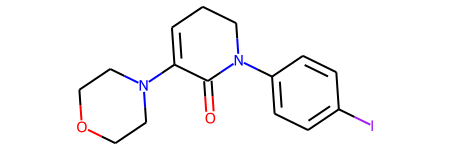

Product


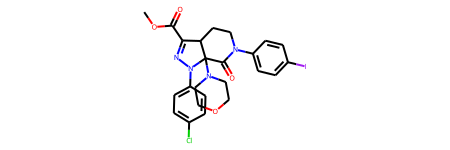

rsig


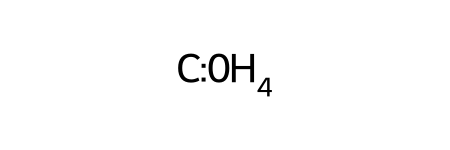

psig


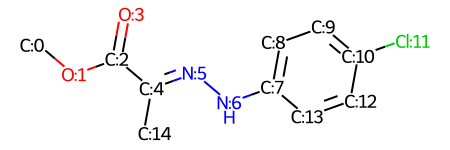

rcen = 0, pcen = 14, rbond = [[1.0, 1.0, 2.0]], pbond = [[1.0, 1.0]]


In [236]:
temp_df = dataset[dataset["rbond"]=="[[1.0, 1.0, 2.0]]"]

r, p, rsig, psig, rcen, pcen, rbond, pbond, cluster_id = temp_df.iloc[i]
print("Reactant")
display(Chem.MolFromSmiles(r))
print("Product")
display(Chem.MolFromSmiles(p))
print("rsig")
display(Chem.MolFromSmiles(rsig))
print("psig")
display(Chem.MolFromSmiles(psig))
print(f"rcen = {rcen}, pcen = {pcen}, rbond = {rbond}, pbond = {pbond}")
i+=1 

# Indexing and searching

In [237]:
import pynauty
import networkx as nx

In [238]:
# Fetch the rsigs using the clusters
unique_rsig_dict = {}
for cluster_id in dataset["rsig_clusters"].unique():
    cluster_df = dataset[dataset["rsig_clusters"] == cluster_id]
    rsig  = Chem.MolFromSmiles(cluster_df.iloc[0]["rsig"])
    unique_rsig_dict[cluster_id] = rsig
    
print(f"There are {len(unique_rsig_dict)} unique rsigs.")

There are 4631 unique rsigs.


In [239]:
# For each rsig, genearate a certificate
def get_mol_certificate(mol):
    adj_mat = Chem.GetAdjacencyMatrix(mol)

    # Create a ring for each atom with size = atomic_num
    atom_nums = np.array([atom.GetAtomicNum() for atom in list(mol.GetAtoms())])
    atom_nums[atom_nums == 6] = 1
    mat_list = []
    for atn in atom_nums:
        new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
        for i in range(atn):
            new_mat[i, (i+1)%atn] = 1
        mat_list.append(new_mat)

    # conbine the rings into a new adj mat
    new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
    idx = 0
    for i in range(len(atom_nums)):
        new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
        idx += atom_nums[i]

    # add original last connections
    idx = 0
    for i, a_i in enumerate(np.cumsum(atom_nums)):
        for j, a_j in enumerate(np.cumsum(atom_nums)):
            new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]

    adj_mat = new_adj_mat
    
    # convert adj matrix to adj dict
    adj_dict = {}
    for i, row in enumerate(adj_mat):
        adj_dict[i] = [x for x, j in enumerate(row) if j]
        
    # get graph
    G = pynauty.Graph(len(adj_dict), directed=False, adjacency_dict=adj_dict)#, vertex_coloring=coloring)
    
    # return certificate
    return pynauty.certificate(G)
        
certificate_to_cluster_id_dict = {}
for _id in tqdm.tqdm(unique_rsig_dict):
    C = get_mol_certificate(unique_rsig_dict[_id])
    if C in certificate_to_cluster_id_dict:
        certificate_to_cluster_id_dict[C].append(_id)
    else:
        certificate_to_cluster_id_dict[C] = [_id]

100%|███████████████████████████████████████████████████████████████████████| 4631/4631 [00:01<00:00, 3565.27it/s]


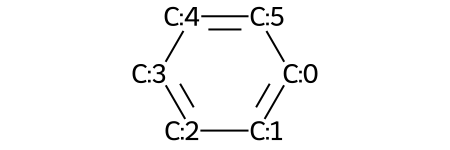

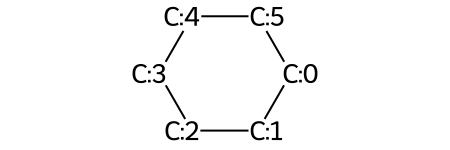

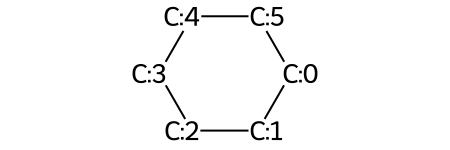

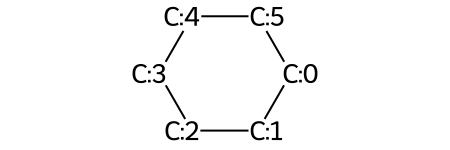

In [240]:
for key in list(certificate_to_cluster_id_dict.keys())[14:]:
    for i in certificate_to_cluster_id_dict[key]:
        display(Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==i].iloc[0]["rsig"]))
    break

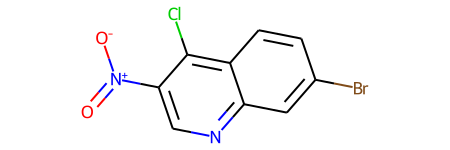

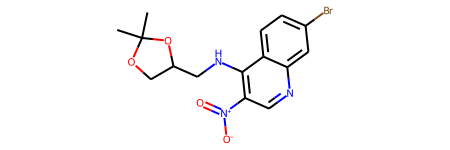

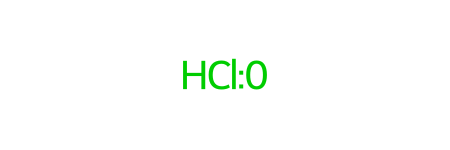

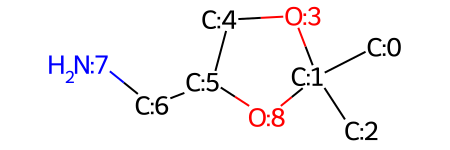

Candidate...


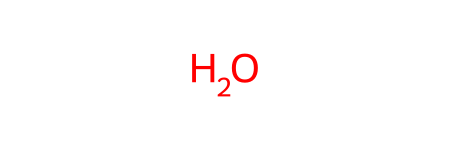

Verification... 3
Verification... 14
Verification... 1839
Verification... 127990
Verification... 150
Verification... 148863
Candidate...


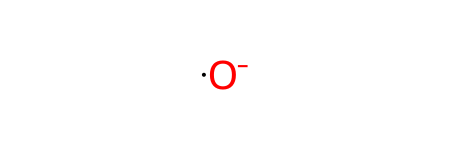

Verification... 3
Verification... 14
Verification... 1839
Verification... 127990
Verification... 150
Verification... 148863
Candidate...


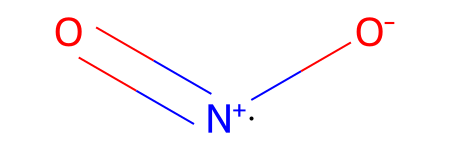

Verification... 98
Verification... 220
Verification... 239253
Candidate...


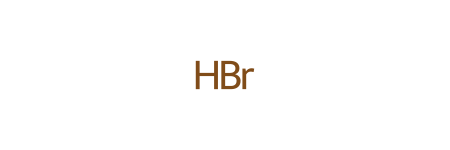

Verification... 21
Verification... 166245
Candidate...


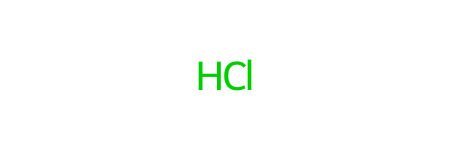

Verification... 1
Verification... 131303
[14, 14, 21, 1]


In [303]:
# For a new molecule, let's find all possible actions applicable
i = 2500
in_mol = Chem.MolFromSmiles(dataset.iloc[i]["reactants"])
out_mol = Chem.MolFromSmiles(dataset.iloc[i]["products"])
rsig = Chem.MolFromSmiles(dataset.iloc[i]["rsig"])
psig = Chem.MolFromSmiles(dataset.iloc[i]["psig"])

display(in_mol)
display(out_mol)
display(rsig)
display(psig)

def verify_action_applicability(mol, cluster_id):
    rsig = Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rsig"])
    rcen = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rcen"]
    rbond = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rbond"]
    
    # Check if the cluster rsig is in mol
    if not mol.HasSubstructMatch(rsig):
        return False
    
    # Check if the rcen matches
    match = mol.GetSubstructMatch(rsig)
    
    cand_rcen = match[rcen]
    cand_atom = mol.GetAtomWithIdx(cand_rcen)
    neighbors = list(map(lambda x: x.GetIdx(), cand_atom.GetNeighbors()))
    if not set(neighbors) - set(match):
        return False

    # Check if bond matches
    bonds = [mol.GetBondBetweenAtoms(cand_rcen, natom).GetBondTypeAsDouble() for natom in set(neighbors) - set(match)]
    rbond = list(map(lambda x: list(map(lambda y: float(y) if y else -1, x.replace("[", "").replace("]", "").replace(" ", "").split(","))), [rbond]))[0]
    bonds.sort()
    rbond.sort()
    if bonds != rbond:
        return False
    
    return True
    

# For each bridge, we find two disconnected components and search the smaller one in our index
G = nx.from_numpy_matrix(Chem.GetAdjacencyMatrix(in_mol))
applicable_actions = []
for x1, x2 in nx.bridges(G):
    mw = Chem.RWMol(in_mol)
    mw.RemoveBond(x1, x2)
    m1, m2 = Chem.MolToSmiles(mw).split(".")
    m = m1 if len(m1) < len(m2) else m2
    candidate = Chem.MolFromSmiles(m)
    print("Candidate...")
    display(candidate)
    cand_certi = get_mol_certificate(candidate)
    if cand_certi in certificate_to_cluster_id_dict:
        for cluster_id in certificate_to_cluster_id_dict[cand_certi]:
            print("Verification...", cluster_id)
            if verify_action_applicability(in_mol, cluster_id):
                applicable_actions.append(cluster_id)
                
print(applicable_actions)

Input molecule


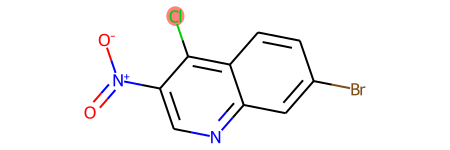

Random rsig chosen (rcen = 0)


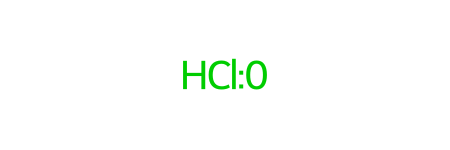

Random psig chosen (pcen = 0)


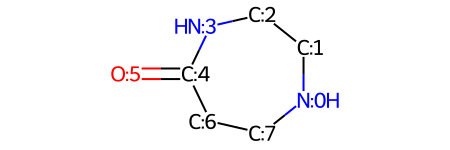

In [331]:
# Pick a random action from all the possible ones
temp_df = dataset[dataset["rsig_clusters"].isin(applicable_actions)]
random_action = temp_df.iloc[int(np.random.random()*temp_df.shape[0])]

print("Input molecule")
display(in_mol)
print(f"Random rsig chosen (rcen = {random_action['rcen']})")
display(Chem.MolFromSmiles(random_action["rsig"]))
print(f"Random psig chosen (pcen = {random_action['pcen']})")
display(Chem.MolFromSmiles(random_action["psig"]))

Input molecule with canditate matches


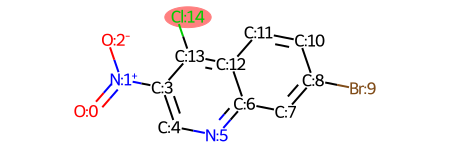

Input molecule without rsig


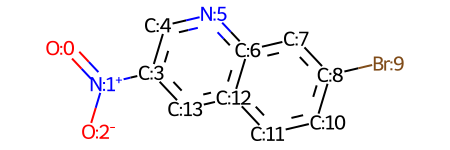

Input molecule with psig


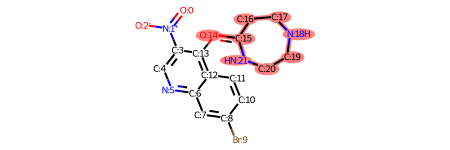

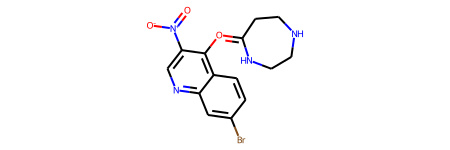

In [341]:
def mol_with_atom_index( mol ):
    '''
    draw molecule with index
    '''
    colored = False
    if hasattr(mol, "__sssAtoms"):
        sss = mol.__sssAtoms
        colored = True
    mol = Chem.Mol(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    if colored:
        mol.__sssAtoms = sss
    return mol

def smiles_without_atom_index( smiles ):
    '''
    Convert smiles with numbers to smiles without numbers
    '''
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).ClearProp( 'molAtomMapNumber' )
    return Chem.MolToSmiles(mol)

def replace_signature(input_mol, rsig, rcen, rbond, psig, pcen, pbond):
    input_mol = Chem.Mol(input_mol)
    matches = input_mol.GetSubstructMatches(Chem.MolFromSmiles(rsig))
    # FIXME: Provide option to use more than just the first match
    match = matches[0]

    # Find the connecting atom idx
    connecting_atoms = []
    for atm_idx in match:
        atom = input_mol.GetAtomWithIdx(atm_idx)
        neighbors = atom.GetNeighbors()
        neighbors_indices = list(map(lambda x: x.GetIdx(), neighbors))
        connecting_atoms.extend(list(map(lambda x: input_mol.GetAtomWithIdx(x), set(neighbors_indices) - set(match))))
    print(connecting_atoms)
    pcen_atom = input_mol.GetAtomWithIdx(int(pcen))
        
    print("Input molecule with canditate matches")
    display(mol_with_atom_index(input_mol))
    rwmol = Chem.RWMol(input_mol)
    for idx in match:
        rwmol.RemoveAtom(idx)
    print("Input molecule without rsig")
    display(mol_with_atom_index(rwmol))

    original_num_atoms = rwmol.GetNumAtoms()
    rwmol.InsertMol(Chem.MolFromSmiles(smiles_without_atom_index(psig)))
#     display(mol_with_atom_index(rwmol))
    
    for c_atom in connecting_atoms:
#         print(c_atom.GetIdx(), pcen_atom.GetIdx()+original_num_atoms)
        rwmol.AddBond(c_atom.GetIdx(), pcen_atom.GetIdx()+original_num_atoms, Chem.BondType.SINGLE)
    
    output_mol = Chem.Mol(rwmol)
    
    temp_mol = Chem.Mol(output_mol)
    temp_mol.GetSubstructMatch(Chem.MolFromSmiles(psig))
    print("Input molecule with psig")
    display(mol_with_atom_index(temp_mol))
    
#     display(Chem.MolFromSmiles(psig))
#     print(pcen)
    
    return output_mol
    
replace_signature(in_mol, random_action["rsig"], random_action["rcen"], [], random_action["psig"], random_action["pcen"], [])

In [249]:
temp_df

,reactants,products,rsig,psig,rcen,pcen,rbond,pbond,rsig_clusters


In [13]:
mol = Chem.MolFromSmiles("CONC")

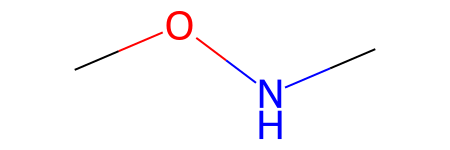

In [14]:
mol

In [152]:
Chem.GetAdjacencyMatrix(mol)

array([[0, 1, 0, 0],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0]], dtype=int32)

In [15]:
mol = Chem.MolFromSmiles("CC(C)C")

In [16]:
adj_mat = Chem.GetAdjacencyMatrix(mol)

# Create a ring for each atom with size = atomic_num
atom_nums = np.array([atom.GetAtomicNum() for atom in list(mol.GetAtoms())])
# atom_nums[atom_nums == 6] = 1
mat_list = []
for atn in atom_nums:
    new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
    for i in range(atn):
        new_mat[i, (i+1)%atn] = 1
    mat_list.append(new_mat)

# conbine the rings into a new adj mat
new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
idx = 0
for i in range(len(atom_nums)):
    new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
    idx += atom_nums[i]
    
# add original last connections
idx = 0
for i, a_i in enumerate(np.cumsum(atom_nums)):
    for j, a_j in enumerate(np.cumsum(atom_nums)):
        new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]
#         print(a_i-1, a_j-1, adj_mat[i, j])

In [17]:
for row in new_adj_mat:
    print(row)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


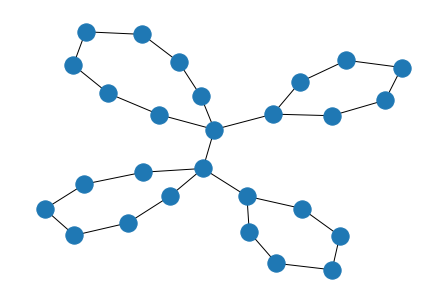

In [156]:
import networkx as nx
G = nx.from_numpy_matrix(new_adj_mat)

nx.draw_kamada_kawai(G)